# **Computer vision**

# **Import Library**

In [ ]:
# colab 관련
from google.colab import drive, files

# pandas, numpy
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#모델링
from keras import Sequential
from keras.layers import *

# **Data Load**

In [ ]:
# 구글 드라이브 연동
drive.mount('cvision')

Drive already mounted at cvision; to attempt to forcibly remount, call drive.mount("cvision", force_remount=True).


In [ ]:
# csv 파일을 데이터 프레임 형식으로 불러오기
train = pd.read_csv('cvision/My Drive/data 2/train.csv')
test = pd.read_csv('cvision/My Drive/data 2/test.csv')
sub = pd.read_csv('cvision/My Drive/data 2/submission.csv')

# **EDA**


In [ ]:
print("데이터의 형태(행, 열):", train.shape) 
train.head()

데이터의 형태(행, 열): (2048, 787)


,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


 ## **Target**

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Digit(Target)')]

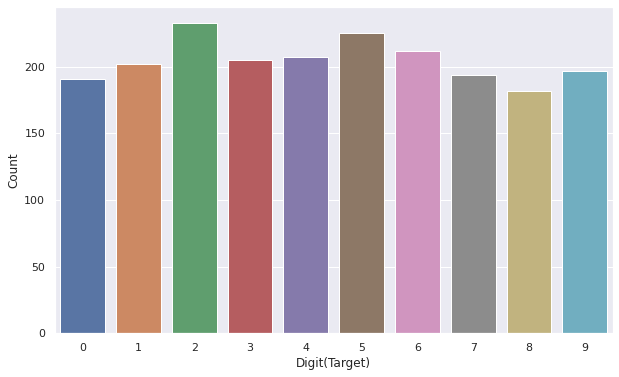

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="digit", data=train)
ax.set(xlabel='Digit(Target)', ylabel='Count')

## **Letter**

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Letter')]

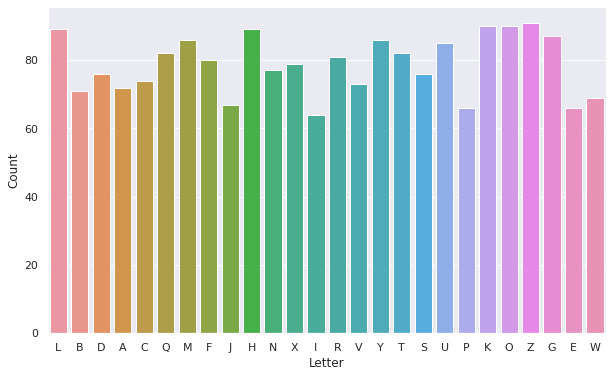

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="letter", data=train)
ax.set(xlabel='Letter', ylabel='Count')

# **Data Preprocessing (데이터 전처리)**

In [ ]:
# 불필요한 column 제거
train2 = train.drop(['id','digit','letter'],1)
test2 = test.drop(['id','letter'],1)

In [ ]:
# 데이터프레임(pd)을 ndarray(np) 형식으로 변환 후 reshape
train2 = train2.values.reshape(-1,28,28,1)
test2 = test2.values.reshape(-1,28,28,1)

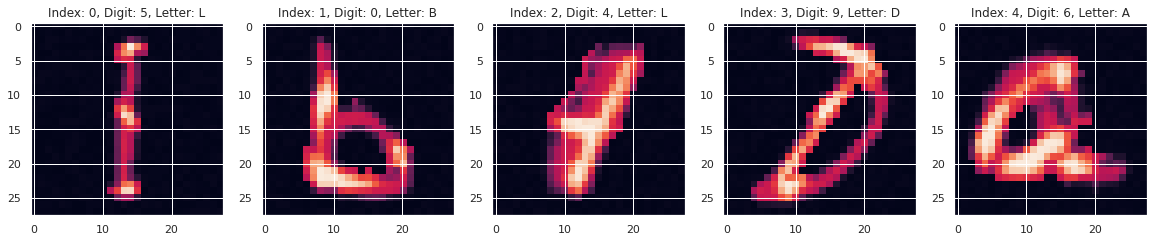

In [ ]:
plt.figure(figsize=(20,4))
for i in range(5):
    img = train2[i].reshape(28,28)
    digit = train.loc[i, 'digit']
    letter = train.loc[i, 'letter']
    plt.subplot(1,5, i + 1)
    plt.title('Index: %i, Digit: %s, Letter: %s'%(i, digit, letter))
    plt.imshow(img)

In [ ]:
# data normalization
train2 = train2/255.0
test2 = test2/255.0

In [ ]:
# 평가셋(validation) 생성
x_train, x_valid, y_train, y_valid = train_test_split(train2, train['digit'], test_size=0.2, random_state=42, stratify = train['digit'])

## 1. ImageDataGenerator로 Data Augmentation


In [ ]:
idg = ImageDataGenerator(rotation_range=45)
idg2 = ImageDataGenerator()

train_generator = idg.flow(x_train,y_train)
valid_generator = idg2.flow(x_valid,y_valid)
test_generator = idg2.flow(test2,shuffle=False)

## 2. Data Augmentation 이미지 시각화

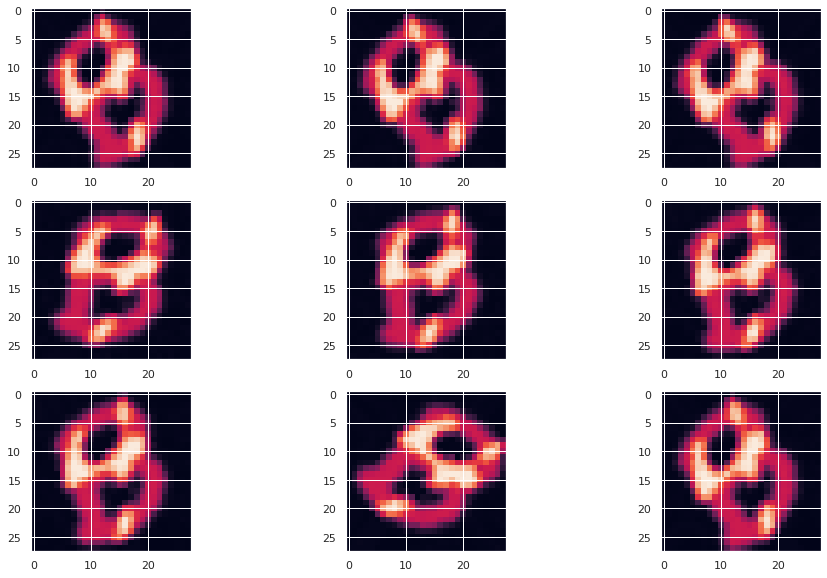

In [ ]:
sample_data = train2[idx].reshape(1,28,28,1)
sample_generator = idg.flow(sample_data, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9) : 
    plt.subplot(3,3,i+1)
    plt.imshow(sample_generator[0].reshape(28,28))

# **Modeling**

## 3. callback 적용하기 

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

reLR = ReduceLROnPlateau(patience=20,verbose=1,factor=0.5) #learning rate scheduler
es = EarlyStopping(patience=30, verbose=1)
mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)

## 4. Dropout
Convolutional Layer, FullyConnected Layer 뒤에 Dropout 추가하기


In [ ]:
model = Sequential()

model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1000,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(x_train, 
                    y_train,
                    validation_data=(x_valid, y_valid),       
                   )

52/52 [==============================] - 1s 22ms/step - loss: 2.2955 - acc: 0.3816 - val_loss: 11.1662 - val_acc: 0.0976


In [ ]:
history.history.keys()
## dict_keys(['loss', 'accuracy', 'get_f1', 'val_loss', 'val_accuracy', 'val_get_f1'])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### 5-1 . 학습 결과 확인 및 시각화
학습 과정을 learning_history 라는 변수에 담기


In [ ]:
learning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])

## 5-2. 학습 결과 확인 및 시각화
1. .history 메소드를 활용하여 불러온 학습결과를 pd.DataFrame()을 사용해 데이터프레임 형식으로 변환
2. val_loss의 최소값 확인

In [ ]:
# save val_loss
hist = pd.DataFrame(learning_history.history)
hist['val_loss'].min()

0.8268301486968994

## 5-3. 학습결과 확인 및 시각화
1. plt.plot을 활용하여 val_loss와 loss 그래프 그리기
2. 제목(title)과 x축 label 입력
3. 범례 추가 (plt.legend())

In [ ]:
hist.columns

Index(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], dtype='object')

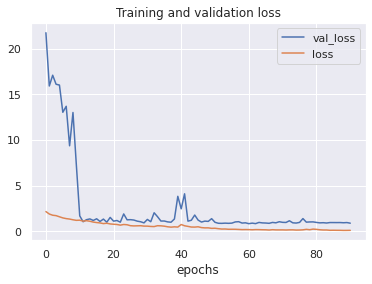

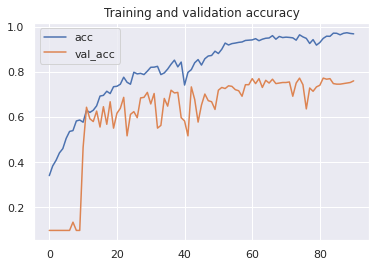

In [ ]:

plt.title('Training and validation loss')
plt.xlabel('epochs')

plt.plot(hist['val_loss'])
plt.plot(hist['loss'])
plt.legend(['val_loss','loss'])

plt.figure()

plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.legend(['acc','val_acc'])
plt.title('Training and validation accuracy')


plt.show()

In [ ]:
model.load_weights('best_cvision.h5')

In [ ]:
result = model.predict(test_generator, verbose=True)

640/640 [==============================] - 3s 4ms/step


## 6. Cross Validation

In [ ]:
# cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

result = 0
for train_index, valid_index in skf.split(train2,train['digit']) :
    
  mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)
  
  x_train = train2[train_index]
  x_valid = train2[valid_index]    
  y_train = train['digit'][train_index]
  y_valid = train['digit'][valid_index]
  
  train_generator = idg.flow(x_train,y_train)
  valid_generator = idg2.flow(x_valid,y_valid)
  test_generator = idg2.flow(test2,shuffle=False)
  
  model = Sequential()

  model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(1000,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(10,activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])
  
  learning_history = model.fit(train_generator,epochs=100, validation_data=valid_generator, callbacks=[es,mc,reLR])
  
  # predict
  model.load_weights('best_cvision.h5')
  result += model.predict(test_generator,verbose=True)/5

# **Submission**

In [ ]:
sub['digit'] = result.argmax(1)

In [ ]:
sub.to_csv('Dacon_cvision_school.csv',index=False)

In [ ]:
from google.colab import files
files.download('Dacon_cvision_school.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>